# Neurodesign: Optimal experimental designs for task fMRI

This notebook contains the code to generate the figures and results from the paper submitted to Journal of Statistical Software.  The first part contains the example results from the neurodesign package.  The second part shows the code to generate Figure 1.

## Examples

### 3.2 Specifying the characteristics of the experiment

In [1]:
from neurodesign import geneticalgorithm
EXP = geneticalgorithm.experiment(
 TR=1.2,
 n_trials=20,
 P = [0.3,0.3,0.4],
 C = [[1,-1,0],[0,1,-1]],
 n_stimuli = 3,
 rho = 0.3,
 stim_duration=1,
 ITImodel = "uniform",
 ITImin = 2,
 ITImax=4
 )

/Users/Joke/anaconda/lib/python2.7/site-packages/neurodesign/geneticalgorithm.py:560: RuntimeWarning: divide by zero encountered in log
  res = (h - 1) * np.log(s) + h * np.log(l) - l * s - np.log(gamma(h))


### 3.3 Generating a design matrix

In [2]:
from neurodesign import geneticalgorithm
DES1 = geneticalgorithm.design(
  order = [0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1],
  ITI = [2]*20,
  experiment = EXP
)

DES1.designmatrix()

DES1.FCalc(weights=[0.25,0.25,0.25,0.25])

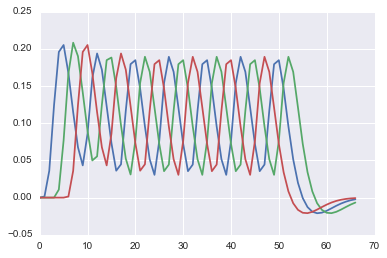

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline # this command is specific for notebooks, and is therefore not included in the paper
plt.plot(DES1.Xconv)

In [6]:
DES2 = geneticalgorithm.design(
    order = [0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1],
    ITI = [2]*20,
    experiment=EXP
)
DES2.designmatrix(); DES2.FCalc(weights=[0.25,0.25,0.25,0.25])
print("Ff of Design 1: "+str(DES1.Ff))
print("Ff of Design 2: "+str(DES2.Ff))
print("Fd of Design 1: "+str(DES1.Fd))
print("Fd of Design 2: "+str(DES2.Fd))


Ff of Design 1: 0.857142857143
Ff of Design 2: 0.428571428571
Fd of Design 1: 0.0878980828509
Fd of Design 2: 0.275934139719


In [8]:
DES3,DES4 = DES1.crossover(DES2,seed=2000)
DES3.order

[0, 1, 2, 0, 1, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [9]:
DES4.order

[0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1]

### 3.4 Optimal design using the genetic algorithm

In [10]:
POP = geneticalgorithm.population(
    experiment=EXP,
    weights=[0,0.5,0.25,0.25],
    preruncycles = 100,
    cycles = 100,
    folder = "./",
    seed=100
    )
POP.naturalselection()


100% |########################################################################|
100% |########################################################################|


## Figure 1

In [1]:
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def spm_hrf(TR,p=[6,16,1,1,6,0,32]):
    p=[float(x) for x in p]
    fMRI_T = 16.0
    TR=float(TR)
    dt  = TR/fMRI_T
    u   = np.arange(p[6]/dt + 1) - p[5]/dt
    hrf=scipy.stats.gamma.pdf(u,p[0]/p[2],scale=1.0/(dt/p[2])) - scipy.stats.gamma.pdf(u,p[1]/p[3],scale=1.0/(dt/p[3]))/p[4]
    good_pts=np.array(range(np.int(p[6]/TR)))*fMRI_T
    good_pts_ls = [int(x) for x in good_pts]
    hrf=hrf[good_pts_ls]
    hrf = hrf/np.sum(hrf);
    return hrf

In [3]:
resolution = 0.25
hrf = spm_hrf(resolution)

In [4]:
ntrials = 15

TR_s = 2
stimDur_s = 0.2
ITI_s = 6
totalDur_s = int((stimDur_s+ITI_s) * ntrials)

# experimental design in seconds
onsets = np.arange(0,totalDur_s,(ITI_s+stimDur_s))
order = np.array([0,1]*int(ntrials/2))
X0_onsets_s = onsets[order==0]+1
X1_onsets_s = onsets[order==1]+1

# experimental design in resolution units
TR = int(TR_s/resolution)
totalDur = int(totalDur_s/resolution)
stimDur = int(stimDur_s/resolution)
X0_onsets = [int(x/resolution) for x in X0_onsets_s]
X1_onsets = [int(x/resolution) for x in X1_onsets_s]


/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 15 but corresponding boolean dimension is 14
/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 15 but corresponding boolean dimension is 14


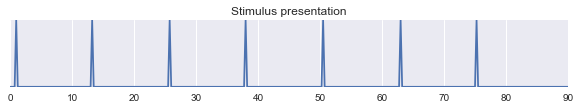

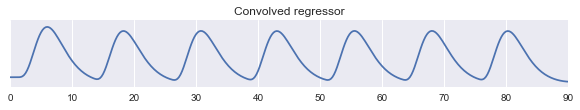

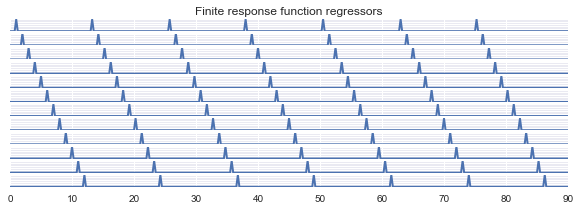

In [16]:
# x-axis
xax = np.arange(372)/4.

# create design matrix (stimulus presentation)
X0 = np.zeros(int(totalDur))
X0[X0_onsets] = 1
for shift in np.arange(1,int(stimDur)):
    ind = [x+shift for x in X0_onsets]
    X0[ind] = 1 

# create HRF model
X0Z_highres = np.convolve(X0,hrf)[:len(X0)]

# create FIR model
delay = 12
X = np.zeros([int(totalDur),delay])
for de in range(delay):
    onsen = [int(x+de/resolution) for x in X0_onsets]
    X[onsen,de] = 1
    for shift in np.arange(1,int(stimDur)):
        ind = [x+shift+de/resolution for x in X0_onsets]
        X[ind,de] = 1 

#plots
plt.figure(figsize=(10,1.2))
plt.plot(xax,X0)
plt.title("Stimulus presentation")
plt.yticks([])
plt.xlim([0,90])
plt.savefig('Figure1a.pdf', bbox_inches='tight')

plt.figure(figsize=(10,1.2))
plt.plot(xax,X0Z_highres)
plt.title("Convolved regressor")
plt.yticks([])
plt.xlim([0,90])
plt.savefig('Figure1b.pdf', bbox_inches='tight')

f, axs = plt.subplots(delay, sharex=True, sharey=True,figsize=(10,3))
for p in range(delay):
    axs[p].plot(xax,X[:,p],lw=2)
    axs[p].set_yticklabels([])
    axs[p].set_xlim([0,90])
axs[0].set_title('Finite response function regressors')
f.subplots_adjust(hspace=0.2)
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

plt.savefig('Figure1c.pdf', bbox_inches='tight')